In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("../data/ASAP2_new_IN_data_only.csv")
df

,essay_id,score,full_text,set,pubpriv,assignment,prompt_name,economically_disadvantaged,student_disability_status,ell_status,race_ethnicity,gender,grade_level,essay_word_count,source,task
0,AAAOPP13416000019936,4,"Being a Seagoing Cowboy is really fun, but als...",test,private,"You have just read the article, 'A Cowboy Who ...","""A Cowboy Who Rode the Waves""",Economically disadvantaged,Not identified as having disability,No,Black/African American,M,6,538.0,MI,Text dependent
1,AAAOPP13416000055926,5,"To whom ever reads this at the end, you might ...",test,public,"You have just read the article, 'A Cowboy Who ...","""A Cowboy Who Rode the Waves""",Not economically disadvantaged,Not identified as having disability,No,Hispanic/Latino,F,6,367.0,MI,Text dependent
2,AAAOPP13416000005911,3,Have you ever wondered about what you might do...,train,0,"You have just read the article, 'A Cowboy Who ...","""A Cowboy Who Rode the Waves""",Economically disadvantaged,Not identified as having disability,No,Two or more races/Other,F,6,498.0,MI,Text dependent
3,AAAOPP13416000019800,3,I believe that you should join the Seagoing Co...,train,0,"You have just read the article, 'A Cowboy Who ...","""A Cowboy Who Rode the Waves""",Not economically disadvantaged,Not identified as having disability,No,Asian/Pacific Islander,F,6,317.0,MI,Text dependent
4,AAAOPP13416000019823,4,Would you like to participate in the Seagoing ...,train,0,"You have just read the article, 'A Cowboy Who ...","""A Cowboy Who Rode the Waves""",Not economically disadvantaged,Not identified as having disability,No,Asian/Pacific Islander,F,6,443.0,MI,Text dependent
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11821,AAAOPP13416000218424,1,We've been discovering things almost everyday....,test,private,You have read the article 'Unmasking the Face ...,The Face on Mars,Economically disadvantaged,Not identified as having disability,No,Black/African American,M,8,259.0,MI,Text dependent
11822,AAAOPP13416000254175,1,In 1976 the queation was and everyone was also...,train,0,You have read the article 'Unmasking the Face ...,The Face on Mars,Not economically disadvantaged,Not identified as having disability,No,Two or more races/Other,M,8,226.0,MI,Text dependent
11823,AAAOPP13416000260386,1,25 years ago there was a face discovered by na...,test,private,You have read the article 'Unmasking the Face ...,The Face on Mars,Not economically disadvantaged,Not identified as having disability,No,Black/African American,M,8,163.0,MI,Text dependent
11824,AAAOPP13416000292300,1,The\n\nfirst thing that i should include in my...,train,0,You have read the article 'Unmasking the Face ...,The Face on Mars,Not economically disadvantaged,Not identified as having disability,No,Black/African American,F,8,292.0,MI,Text dependent


In [3]:
# Random sampling would be fine, but lets stratify for fun...
strata = [
    "score",
    "prompt_name",
    "economically_disadvantaged",
    "student_disability_status",
    "ell_status",
    "race_ethnicity",
]


def create_stratified_split(
    df, train_size=0.5, dev_size=0.25, test_size=0.25, random_state=42
):
    # Create a combined strata column
    combined_strata = df[strata].astype(str).agg("_".join, axis=1)

    # Initialize the split column with a placeholder
    split = pd.Series(pd.NA, index=df.index)

    skf = StratifiedKFold(
        n_splits=int(1 / train_size), shuffle=True, random_state=random_state
    )
    train_idx, temp_idx = next(skf.split(combined_strata, combined_strata))

    # Assign train labels
    split.loc[train_idx] = "train"

    # Create a temporary dataframe for the second split
    temp_strata = combined_strata.iloc[temp_idx].copy()

    # Then split temp into dev and test
    dev_ratio = dev_size / (dev_size + test_size)
    skf2 = StratifiedKFold(
        n_splits=int(1 / dev_ratio), shuffle=True, random_state=random_state
    )
    dev_idx, test_idx = next(skf2.split(temp_strata, temp_strata))

    # Get the original indices
    dev_original_idx = temp_strata.index[dev_idx]
    test_original_idx = temp_strata.index[test_idx]

    # Assign dev and test labels
    split.loc[dev_original_idx] = "dev"
    split.loc[test_original_idx] = "test"

    # Verify the split proportions
    split_counts = split.value_counts(normalize=True)
    print(f"Train: {split_counts.get('train', 0):.2f}")
    print(f"Dev  : {split_counts.get('dev', 0):.2f}")
    print(f"Test : {split_counts.get('test', 0):.2f}")

    return split


df["stratified_split"] = create_stratified_split(df)

Train: 0.50
Dev  : 0.25
Test : 0.25


/opt/conda/lib/python3.11/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(


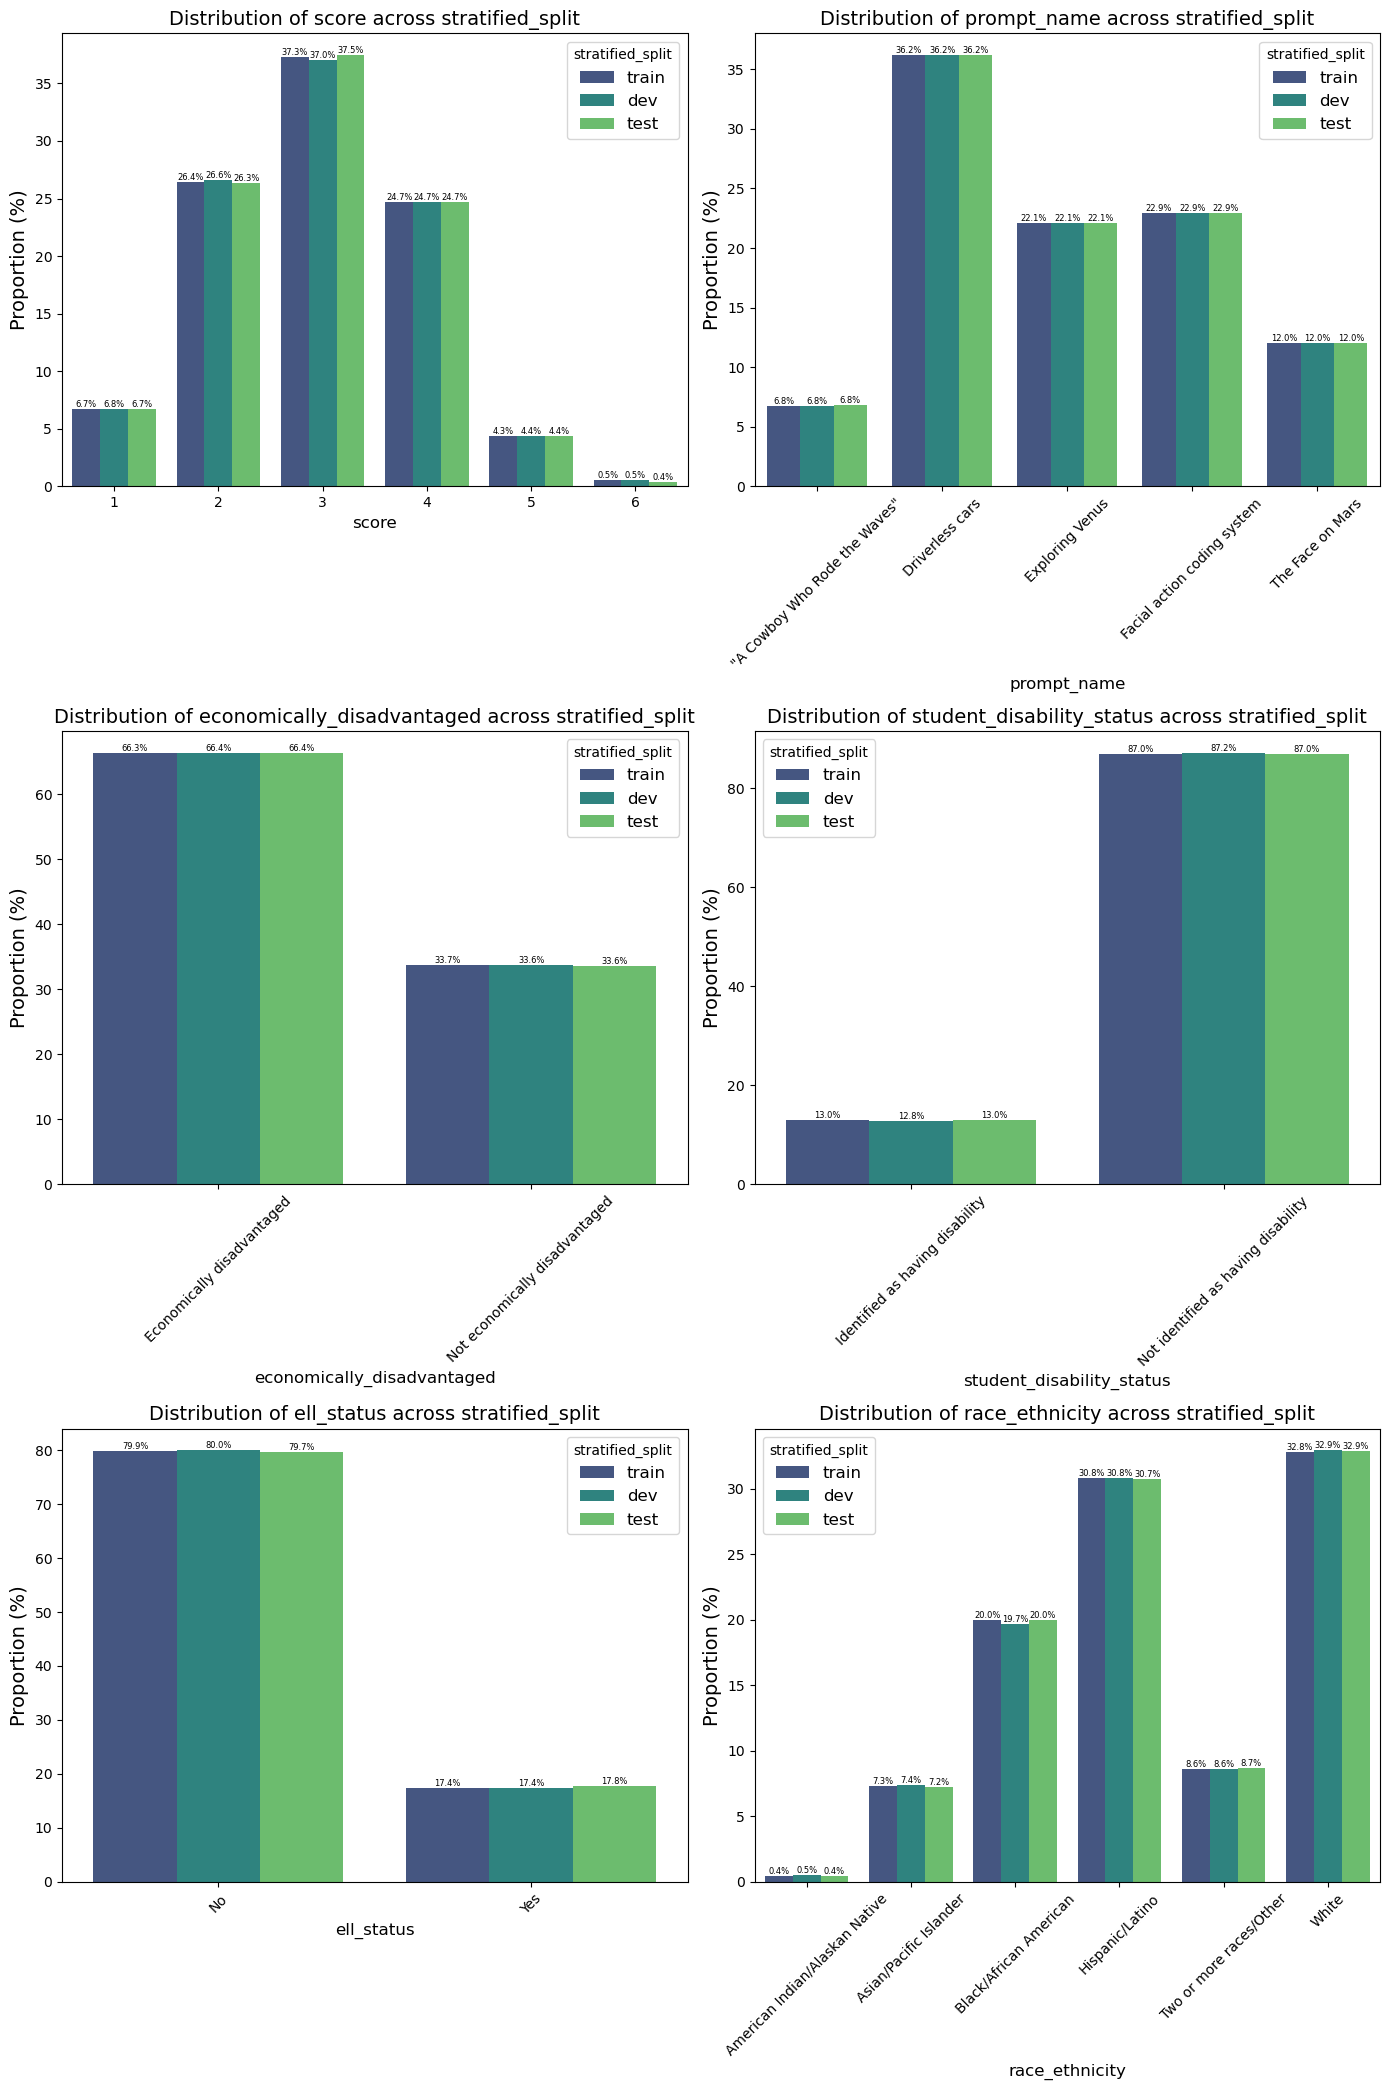

In [7]:
def create_grouped_barchart(df, var_col, ax, split_col="pubpriv"):
    """
    Create a grouped bar chart showing the percentage distribution of a variable
    across different levels of pubpriv, separated by prompt_name.
    """
    # Calculate percentage distribution
    # Group by split_col and the variable, then normalize within each group
    grouped = df.groupby([split_col, var_col]).size().reset_index(name="count")
    total = df.groupby(split_col).size().reset_index(name="total")

    # Merge the two dataframes
    merged = pd.merge(grouped, total, on=split_col)

    # Calculate percentage
    merged["percentage"] = merged["count"] / merged["total"] * 100

    # Create the grouped bar chart
    sns.barplot(
        x=var_col,
        y="percentage",
        hue=split_col,
        hue_order=["train", "dev", "test"],
        data=merged,
        palette="viridis",
        errorbar=None,
        ax=ax,
    )

    # Add labels and title
    ax.set_title(f"Distribution of {var_col} across {split_col}", fontsize=14)
    ax.set_xlabel(var_col, fontsize=12)
    ax.set_ylabel("Proportion (%)", fontsize=14)
    ax.legend(title=split_col, fontsize=12)

    if var != "score":
        ax.set_xticks(merged[var_col].unique())
        ax.set_xticklabels(merged[var_col].unique(), rotation=45)

    # Add percentage labels on the bars
    for container in ax.containers:
        ax.bar_label(container, fmt="%.1f%%", fontsize=6)

    plt.tight_layout()
    return ax


SPLIT_COL = "stratified_split"
fig, axes = plt.subplots(3, 2, figsize=(14, 21))
for var, ax in zip(strata, np.ravel(axes)):
    create_grouped_barchart(df, var, ax, split_col=SPLIT_COL)

plt.show()
plt.savefig(f"../results/partition_splits.png", dpi=300, bbox_inches="tight")
plt.close()

In [5]:
df.to_csv("../data/ASAP2_new_IN_data_only_w_splits.csv", index=False)